GROUP MEMBERS:

Deepak Nair(B_638)

Soham Mhatre(B_637)

Harish Nair(B_640)

Dhanish Nair(B_639)

# **Section 1: Load the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NLP_Project_dataset - Extended_NLP_Project_dataset.csv to NLP_Project_dataset - Extended_NLP_Project_dataset.csv


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313470 sha256=2c7c471ba0f37f40474f76f04b33b6d4829f9b51917f650a156bc3254ac68ee7
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import fasttext.util
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv("Extended_NLP_Project_dataset.csv")
train.head()

,Disease,Description
0,Fungal Infection,"Lately, I have been experiencing symptoms such..."
1,Fungal Infection,"I have noticed persistent painful blisters, pe..."
2,Fungal Infection,"I have noticed persistent itchy patches, redne..."
3,Fungal Infection,"I have noticed persistent itchy patches, redne..."
4,Fungal Infection,"Lately, I have been experiencing symptoms such..."


# **SECTION: 2 Perform Exploratory Data Analysis**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Disease      1200 non-null   object
 1   Description  1200 non-null   object
dtypes: object(2)
memory usage: 18.9+ KB
None
                 Disease                                        Description
count               1200                                               1200
unique                30                                                947
top     Fungal Infection  For the past few days, I have been suffering f...
freq                  40                                                  5


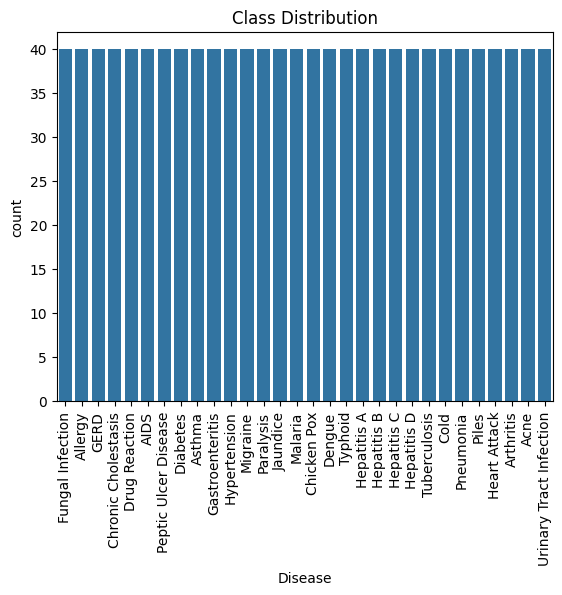

Disease        0
Description    0
dtype: int64


In [ ]:
print(train.info())
print(train.describe())
sns.countplot(x='Disease', data=train)
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.show()
print(train.isnull().sum())

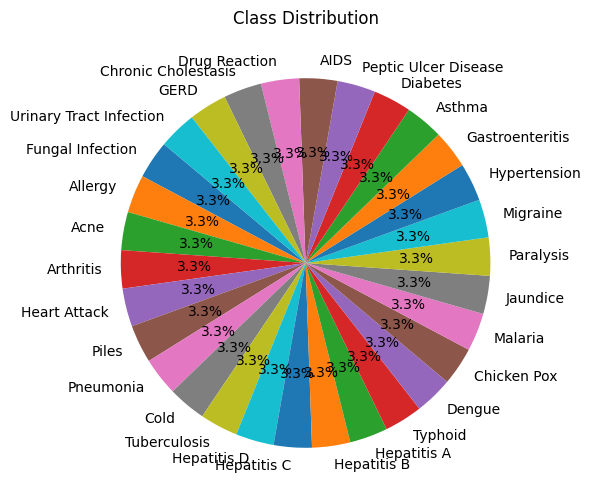

In [ ]:
class_distribution = train['Disease'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution")
plt.show()

# **Section 3: Perform Text Processing on Dataset**

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = text.lower()
    return text

train['cleaned_text'] = train['Description'].apply(clean_text)
train[['Description', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Description,cleaned_text
0,"Lately, I have been experiencing symptoms such...",lately i have been experiencing symptoms such ...
1,"I have noticed persistent painful blisters, pe...",i have noticed persistent painful blisters pee...
2,"I have noticed persistent itchy patches, redne...",i have noticed persistent itchy patches rednes...
3,"I have noticed persistent itchy patches, redne...",i have noticed persistent itchy patches rednes...
4,"Lately, I have been experiencing symptoms such...",lately i have been experiencing symptoms such ...


# **Section 4: Generate NLP-Based Features**

In [ ]:
def generate_nlp_features(data):
    data['char_count'] = data['cleaned_text'].apply(len)
    data['word_count'] = data['cleaned_text'].apply(lambda x: len(x.split()))
    data['avg_word_length'] = data['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    data['stopword_count'] = data['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    return data

train = generate_nlp_features(train)
print("Training Data with NLP Features:")
print(train[['char_count', 'word_count', 'avg_word_length', 'stopword_count']].head())

Training Data with NLP Features:
   char_count  word_count  avg_word_length  stopword_count
0         310          53         4.867925              23
1         345          54         5.407407              21
2         350          56         5.267857              22
3         339          55         5.181818              22
4         324          56         4.803571              24


# **Section 5: Generate Bag of Words, TFIDF, and FastText Features**

In [ ]:
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
#!gunzip cc.en.300.bin.gz

--2025-03-16 03:35:11--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.238.217.17, 18.238.217.77, 18.238.217.58, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.217.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  84.3MB/s    in 40s     

2025-03-16 03:35:52 (106 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
fasttext.util.download_model('en', if_exists='ignore')
ft_model = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text):
    words = text.split()
    if words:
        return np.mean([ft_model.get_word_vector(word) for word in words], axis=0)
    else:
        return np.zeros(300)

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(train['cleaned_text']).toarray()

bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(train['cleaned_text'])

train['fasttext_embeddings'] = train['cleaned_text'].apply(get_fasttext_embeddings)
X_fasttext = np.vstack(train['fasttext_embeddings'])

print(f"Bag of Words: {X_bow.shape}")
print(f"\nTF-IDF Shapes:,{X_tfidf.shape}")
print(f"\nFastText Shapes: {X_fasttext.shape}")


Training: (1200, 231)

TF-IDF Shapes:
Training: (1200, 231)

FastText Shapes:
Training: (1200, 300)


# **Section 6: Train All Supervised Models on NLP-Based Features**

In [ ]:
#logistic regression
X_nlp = train[['char_count', 'word_count', 'avg_word_length', 'stopword_count']].values
label_encoder = LabelEncoder()
Y = LabelEncoder().fit_transform(train['Disease'])
X_train, X_test, y_train, y_test = train_test_split(X_nlp, Y, test_size=0.2, random_state=42, stratify=Y)
model1 = LogisticRegression(solver='liblinear',max_iter=1000)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred1))

Accuracy: 0.1
              precision    recall  f1-score   support

           0       0.21      0.38      0.27         8
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.05      0.12      0.07         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.10      0.38      0.16         8
           9       0.00      0.00      0.00         8
          10       0.12      0.25      0.16         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.13      0.25      0.17         8
          14       0.06      0.12      0.08         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00         8
          17 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#SVM
model2 = SVC(kernel ='linear')
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred2))

Accuracy: 0.1
              precision    recall  f1-score   support

           0       0.11      0.25      0.15         8
           1       0.15      0.25      0.19         8
           2       0.23      0.38      0.29         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.12      0.12      0.12         8
           9       0.00      0.00      0.00         8
          10       0.17      0.12      0.14         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.25      0.25      0.25         8
          14       0.06      0.12      0.08         8
          15       0.06      0.12      0.08         8
          16       0.00      0.00      0.00         8
          17 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#random forest
model3 = RandomForestClassifier(n_estimators=100, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy: {accuracy3}')
print(classification_report(y_test, y_pred3))

Accuracy: 0.24583333333333332
              precision    recall  f1-score   support

           0       0.43      0.38      0.40         8
           1       0.33      0.25      0.29         8
           2       0.09      0.12      0.11         8
           3       0.08      0.12      0.10         8
           4       0.43      0.38      0.40         8
           5       0.50      0.38      0.43         8
           6       0.12      0.12      0.12         8
           7       0.33      0.12      0.18         8
           8       0.43      0.38      0.40         8
           9       0.29      0.25      0.27         8
          10       0.09      0.25      0.13         8
          11       0.27      0.38      0.32         8
          12       0.29      0.25      0.27         8
          13       0.25      0.25      0.25         8
          14       0.20      0.25      0.22         8
          15       0.14      0.12      0.13         8
          16       0.00      0.00      0.00        

In [ ]:
model4 = KNeighborsClassifier(n_neighbors=4)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
accuracy4 = accuracy_score(y_test, y_pred4)
print(f'Accuracy: {accuracy4}')
print(classification_report(y_test, y_pred4))

Accuracy: 0.18333333333333332
              precision    recall  f1-score   support

           0       0.07      0.14      0.09         7
           1       0.10      0.40      0.16         5
           2       0.12      0.20      0.15        10
           3       0.08      0.14      0.11         7
           4       0.08      0.09      0.09        11
           5       0.19      0.33      0.24         9
           6       0.08      0.12      0.10         8
           7       0.23      0.33      0.27         9
           8       0.00      0.00      0.00         8
           9       0.40      0.18      0.25        11
          10       0.22      0.22      0.22         9
          11       0.25      0.33      0.29         3
          12       0.22      0.22      0.22         9
          13       0.50      0.33      0.40         9
          14       0.10      0.20      0.13         5
          15       0.29      0.29      0.29         7
          16       0.17      0.14      0.15        

# **SECTION 7-9: Train Models on BoW, TFIDF, and FastText Features**

In [ ]:
#logictic regression
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

print(f'BoW Accuracy: {accuracy_score(y_test, y_pred1)}')
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred1)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred1)}')

BoW Accuracy: 1.0
TFIDF Accuracy: 0.975
FastText Accuracy: 0.075


In [ ]:
#SVM
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred2)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred2)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred2)}')

BoW Accuracy: 1.0
TFIDF Accuracy: 1.0
FastText Accuracy: 0.0125


In [ ]:
#random forest
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred3)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred3)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred3)}')

BoW Accuracy: 1.0
TFIDF Accuracy: 1.0
FastText Accuracy: 0.9375


In [ ]:
#Knn
X_train, X_test, y_train, y_test = train_test_split(X_bow , Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'BoW Accuracy: {accuracy_score(y_test, y_pred4)}')

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'TFIDF Accuracy: {accuracy_score(y_test, y_pred4)}')

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, Y, test_size=0.2, random_state=42)
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)
print(f'FastText Accuracy: {accuracy_score(y_test, y_pred4)}')

BoW Accuracy: 0.7166666666666667
TFIDF Accuracy: 0.8958333333333334
FastText Accuracy: 0.5833333333333334


# **Section 10:Train Models on All Combined Features with TFIDF**

In [ ]:
#RF
X_train_combined = np.hstack([X_nlp, X_tfidf, X_fasttext])
X_train, X_test, y_train, y_test = train_test_split(X_train_combined , Y, test_size=0.2, random_state=42)
model3 = RandomForestClassifier(n_estimators=100)
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)
accuracy = accuracy_score(y_test, y_pred3)
print(f'Combined Features Accuracy (Random Forest): {accuracy}')
print(classification_report(y_test, y_pred3))

Combined Features Accuracy (Random Forest): 0.9958333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         9
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00         9
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         9
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         5
          15       0.88      1.00      0.93         7
          16      

# **SECTION 11: Save the Model and Make Predictions on Real-World Input**

In [ ]:
# used RF model
joblib.dump(model3, 'disease_classification_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
def predict_disease(user_input):
    user_input_cleaned = clean_text(user_input)

    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    label_encoder = joblib.load('label_encoder.pkl')
    loaded_model = joblib.load('disease_classification_model.pkl')

    user_input_tfidf = vectorizer.transform([user_input_cleaned]).toarray()
    user_input_fasttext = np.vstack([get_fasttext_embeddings(user_input_cleaned)])
    user_input_nlp = np.array([[len(user_input_cleaned), len(user_input_cleaned.split()),
                                np.mean([len(word) for word in user_input_cleaned.split()]) if user_input_cleaned.split() else 0,
                                len([word for word in user_input_cleaned.split() if word in stop_words])]])

    user_input_combined = np.hstack((user_input_nlp, user_input_tfidf, user_input_fasttext))

    prediction = loaded_model.predict(user_input_combined)
    predicted_disease = label_encoder.inverse_transform(prediction)[0]

    return predicted_disease

print("Welcome to our DDSH clinic!!!")
user_symptoms = input("Please enter your condition in 5-6 sentences so we can predict the disease: ")
predicted_disease = predict_disease(user_symptoms)
print(f'Predicted Disease: {predicted_disease}')

Welcome to our DDSH clinic!!!
Please enter your condition in 5-6 sentences so we can predict the disease: I have noticed persistent loss of appetite, nausea, and itchy skin for the past few weeks. It has been affecting my daily routine, making it difficult to exercise without discomfort. Sometimes, I also experience nausea. The symptoms seem to fluctuate, but overall, they have been getting worse. Seeking medical attention seems necessary at this point.
Predicted Disease: Jaundice


# **SECTION 12 : Provide Analysis on Results**

In NLP models, there are four types :- Logistic regression, KNN, SVM and Random Forest with features of TFIDF, BOW and FASTTEXT.

Logistic regression :-

       BoW Accuracy: 1.0,
       TFIDF Accuracy: 0.975,
       FastText Accuracy: 0.075.

SVM :-

       BoW Accuracy: 1.0,
       TFIDF Accuracy: 1.0,
       FastText Accuracy: 0.012,

KNN:-

      BoW Accuracy: 0.71,
      TFIDF Accuracy: 0.89,
      FastText Accuracy: 0.58.

Random Forest :-

      BoW Accuracy: 1.0,
      TFIDF Accuracy: 1.0,
      FastText Accuracy: 0.9375.





Which feature set (NLP features, BoW, TFIDF, FastText, combined features) performed the best? Why do you think that is?


TF-IDF and BOW performed well. because both effectively capture word frequency and importance, making them well-suited for structured text classification tasks, particularly when the dataset is well-prepared and not heavily reliant on contextual relationships.

Reflect on any challenges or interesting findings during the task.

Yes, traing a model with features tfidf, bow, and fasttext was quit interesting and was never done before. while biggest challenge was to build huga dataset. which contains description of each disease in 5 to 6 sectence.



I think instate of taking input as 5 to 6 sentence, simply 5 to 6 only symptoms would have been resulted in better accuracy.